In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from BP import BackpropagationNN
from LVQ import LVQ
from ELM import ExtremeLearningMachine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score


In [2]:
data = pd.read_csv("data/fitness-tracker.csv")

data.head()

,user_id,date,steps,calories_burned,distance_km,active_minutes,sleep_hours,heart_rate_avg,workout_type,weather_conditions,location,mood
0,468,2023-01-01,4530,2543.02,16.10,613,1.5,176,Walking,Clear,Park,Tired
1,879,2023-01-01,11613,1720.76,8.10,352,6.3,128,Cycling,Fog,Park,Happy
2,152,2023-01-01,27335,1706.35,3.57,236,6.7,134,Yoga,Snow,Park,Neutral
3,311,2023-01-01,13459,2912.38,6.41,1329,11.6,116,Swimming,Rain,Office,Tired
4,759,2023-01-01,15378,3344.51,17.88,52,7.4,84,Swimming,Rain,Office,Neutral


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   user_id             1000000 non-null  int64  
 1   date                1000000 non-null  object 
 2   steps               1000000 non-null  int64  
 3   calories_burned     1000000 non-null  float64
 4   distance_km         1000000 non-null  float64
 5   active_minutes      1000000 non-null  int64  
 6   sleep_hours         1000000 non-null  float64
 7   heart_rate_avg      1000000 non-null  int64  
 8   workout_type        856880 non-null   object 
 9   weather_conditions  1000000 non-null  object 
 10  location            1000000 non-null  object 
 11  mood                1000000 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 91.6+ MB


In [4]:
data = data.drop(columns=["user_id", "date", "location"])

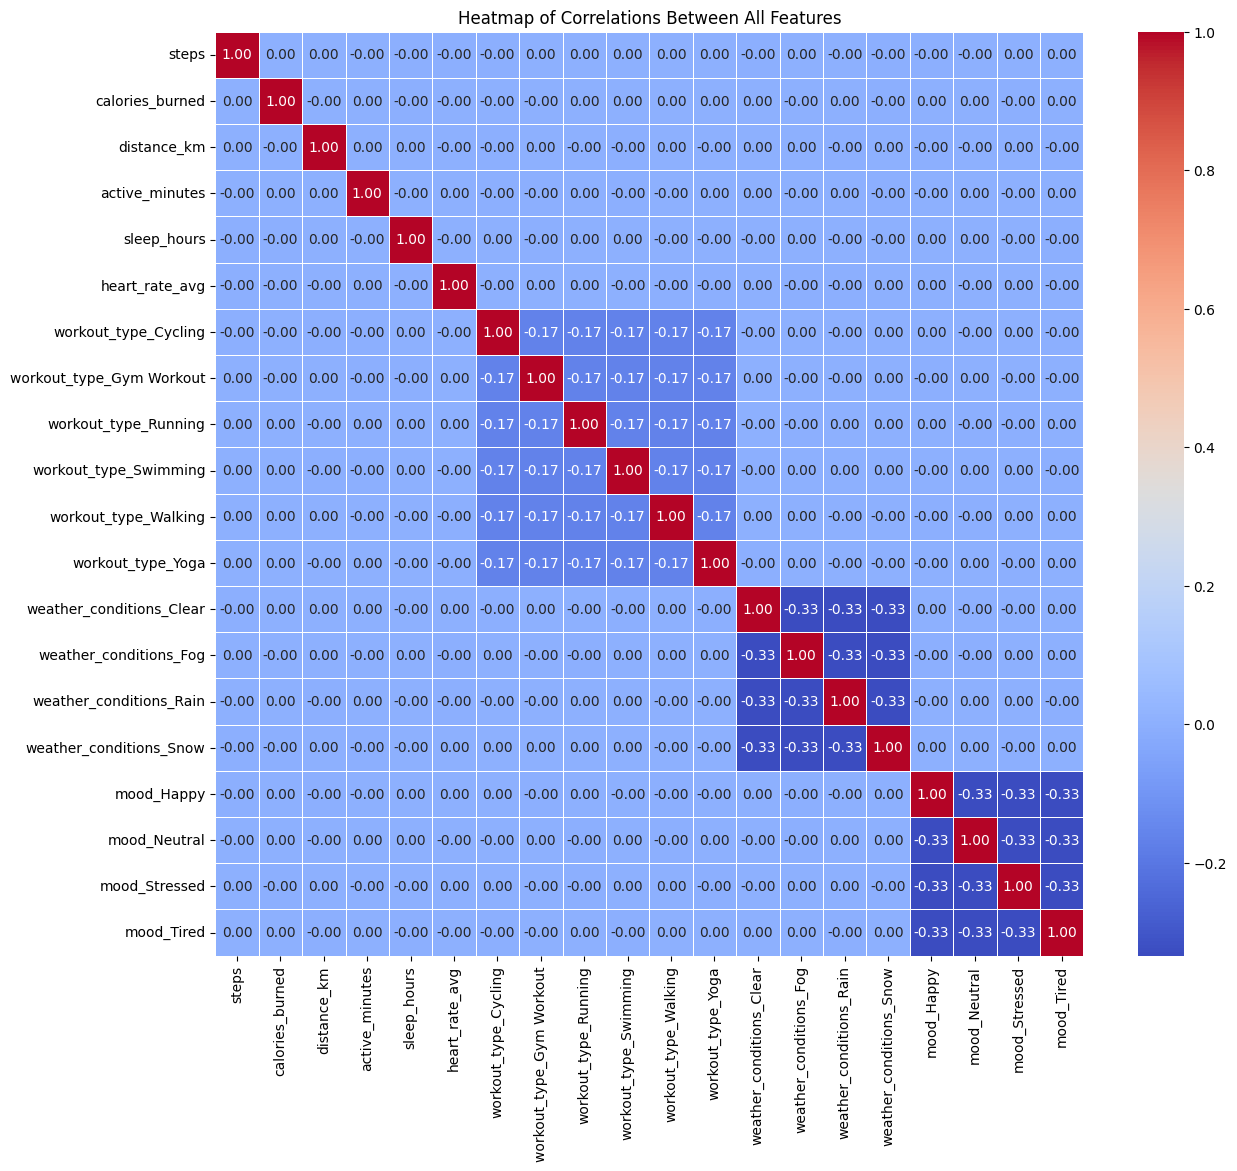

In [5]:
data_encoded = pd.get_dummies(data)

correlation_matrix = data_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Correlations Between All Features")
plt.show()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   steps               1000000 non-null  int64  
 1   calories_burned     1000000 non-null  float64
 2   distance_km         1000000 non-null  float64
 3   active_minutes      1000000 non-null  int64  
 4   sleep_hours         1000000 non-null  float64
 5   heart_rate_avg      1000000 non-null  int64  
 6   workout_type        856880 non-null   object 
 7   weather_conditions  1000000 non-null  object 
 8   mood                1000000 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 68.7+ MB


In [7]:
data = data.dropna(subset=["workout_type"])

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 856880 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   steps               856880 non-null  int64  
 1   calories_burned     856880 non-null  float64
 2   distance_km         856880 non-null  float64
 3   active_minutes      856880 non-null  int64  
 4   sleep_hours         856880 non-null  float64
 5   heart_rate_avg      856880 non-null  int64  
 6   workout_type        856880 non-null  object 
 7   weather_conditions  856880 non-null  object 
 8   mood                856880 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 65.4+ MB


In [8]:
# categorical_columns = ['weather_conditions', 'mood']
# encoder = OneHotEncoder(sparse_output=False)  # Gunakan sparse_output
# encoded_features = encoder.fit_transform(data[categorical_columns])

In [9]:
# numerical_columns = ['steps', 'calories_burned', 'distance_km', 'active_minutes', 'sleep_hours', 'heart_rate_avg']
# numerical_data = data[numerical_columns].values

# scaler = MinMaxScaler()
# normalized_data = scaler.fit_transform(numerical_data)

In [10]:
# X = np.hstack([normalized_data, encoded_features])

In [11]:
# label_encoder = OneHotEncoder(sparse_output=False)
# y = label_encoder.fit_transform(data[['workout_type']])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# input_size = X_train.shape[1]  # Jumlah fitur
# hidden_size = 10  # Neuron di hidden layer
# output_size = y_train.shape[1]  # Jumlah kelas (one-hot encoded)
# learning_rate = 0.01

# # 4. Inisialisasi Model
# bp_model = BackpropagationNN(input_size, hidden_size, output_size, learning_rate)

# # 5. Pelatihan Model
# bp_model.fit(X_train, y_train, epochs=1000)

# # 6. Evaluasi Model
# # Prediksi
# y_pred = bp_model.predict(X_test)

# # Konversi probabilitas ke kelas
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_test_classes = np.argmax(y_test, axis=1)

# # Hitung akurasi
# accuracy = accuracy_score(y_test_classes, y_pred_classes)
# print(f"Accuracy: {accuracy:.2f}")

# # Interpretasi Hasil
# print("Predicted classes:", y_pred_classes)
# print("Actual classes:   ", y_test_classes)

In [13]:
data_elm = data.copy()

le_workout = LabelEncoder()
data['workout_type'] = le_workout.fit_transform(data['workout_type'])

le_mood = LabelEncoder()
data['mood'] = le_mood.fit_transform(data['mood'])

data_elm = pd.get_dummies(data, columns=['weather_conditions'], drop_first=True)

X_elm = data_elm.drop(columns=['workout_type', 'mood']) 
y_workout_elm = data_elm['workout_type'] 
y_mood_elm = data_elm['mood'] 

# Normalisasi fitur
scaler = MinMaxScaler()
X_elm = scaler.fit_transform(X_elm)

# One-hot encode target
ohe_elm = OneHotEncoder(sparse_output=False)
y_workout_ohe_elm = ohe_elm.fit_transform(y_workout_elm.values.reshape(-1, 1))
y_mood_ohe_elm = ohe_elm.fit_transform(y_mood_elm.values.reshape(-1, 1))

# Split data
X_train, X_test, y_train_workout, y_test_workout = train_test_split(X_elm, y_workout_ohe_elm, test_size=0.2, random_state=42)
_, _, y_train_mood, y_test_mood = train_test_split(X_elm, y_mood_ohe_elm, test_size=0.2, random_state=42)


In [14]:
elm_workout = ExtremeLearningMachine(input_size=X_train.shape[1], hidden_size=100, activation_function='sigmoid')
elm_mood = ExtremeLearningMachine(input_size=X_train.shape[1], hidden_size=100, activation_function='sigmoid')

# Latih model untuk workout_type
elm_workout.fit(X_train, y_train_workout)

# Latih model untuk mood
elm_mood.fit(X_train, y_train_mood)

# Prediksi pada data uji
y_pred_workout = elm_workout.predict(X_test)
y_pred_mood = elm_mood.predict(X_test)

# Decode hasil prediksi dan ground truth dengan argmax untuk mendapatkan label kelas
y_pred_workout_labels = np.argmax(y_pred_workout, axis=1)
y_pred_mood_labels = np.argmax(y_pred_mood, axis=1)
y_test_workout_labels = np.argmax(y_test_workout, axis=1)
y_test_mood_labels = np.argmax(y_test_mood, axis=1)

# Menggunakan le_workout dan le_mood untuk mengubah kembali hasil prediksi dan label ke bentuk aslinya
y_pred_workout_labels = le_workout.inverse_transform(y_pred_workout_labels)
y_pred_mood_labels = le_mood.inverse_transform(y_pred_mood_labels)
y_test_workout_labels = le_workout.inverse_transform(y_test_workout_labels)
y_test_mood_labels = le_mood.inverse_transform(y_test_mood_labels)

# Evaluasi
from sklearn.metrics import classification_report
print("Classification Report for Workout Type:")
print(classification_report(y_test_workout_labels, y_pred_workout_labels))

print("Classification Report for Mood:")
print(classification_report(y_test_mood_labels, y_pred_mood_labels))


Classification Report for Workout Type:
              precision    recall  f1-score   support

     Cycling       0.17      0.17      0.17     28716
 Gym Workout       0.17      0.18      0.17     28924
     Running       0.17      0.20      0.18     28476
    Swimming       0.17      0.13      0.14     28544
     Walking       0.17      0.16      0.16     28415
        Yoga       0.17      0.18      0.17     28301

    accuracy                           0.17    171376
   macro avg       0.17      0.17      0.17    171376
weighted avg       0.17      0.17      0.17    171376

Classification Report for Mood:
              precision    recall  f1-score   support

       Happy       0.25      0.27      0.26     42969
     Neutral       0.25      0.27      0.26     42959
    Stressed       0.25      0.27      0.26     42771
       Tired       0.25      0.19      0.22     42677

    accuracy                           0.25    171376
   macro avg       0.25      0.25      0.25    171376
weigh